In [2]:
import os
from diffsky.experimental.disk_bulge_modeling.generate_bulge_disk_sample import (
    get_bulge_disk_test_sample,
    get_bulge_disk_decomposition,
)
from diffaux.validation.plot_utilities import get_zindexes
# or from lsstdesc_diffsky.disk_bulge_modeling.

from jax import random as jran
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict, namedtuple
from itertools import zip_longest
from diffaux.validation.plot_disk_bulge import (
    plot_qs_profiles_for_zvals,
    plot_qs_profiles,
    plot_q_profile,
    plot_q_vs_xs_color_scatter,
    plot_q_with_cuts,
    plot_q1_vs_q2,
    plot_q1_q2,
    plot_q_vs_q_x_at_z_scatter,
    plot_q_vs_qx_at_z_profile,
)

from diffaux.validation.plot_utilities import get_nrow_ncol

ran_key = jran.key(0)

In [3]:
halo_key, ran_key = jran.split(ran_key, 2)
lgmp_min = 11.0
redshift = 0.05
Lbox = 75.0
diffstar_cens = get_bulge_disk_test_sample(halo_key, lgmp_min=lgmp_min, redshift=redshift, Lbox=Lbox)
print(list(diffstar_cens.keys()))

Generated data shape =  (6439, 100)
['subcat', 't_table', 't_obs', 'sfh', 'smh', 'mc_quenched', 'sfh_params', 'logsm_obs', 'logssfr_obs', 'sfh_ms', 'sfh_q', 'frac_q', 'sfh_params_ms', 'sfh_params_q', 'sSFR', 'z_table']


In [4]:
zvalues = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
redshifts = diffstar_cens["z_table"]
zindexes, zs = get_zindexes(zvalues, redshifts)
print(len(redshifts))

100


## New Fbulge Model

In [6]:
from diffsky.experimental.disk_bulge_modeling.mc_disk_bulge import DEFAULT_FBULGE_2dSIGMOID_PARAMS

disk_bulge_key, ran_key = jran.split(ran_key, 2)

diffstar_cens = get_bulge_disk_decomposition(
    disk_bulge_key,
    diffstar_cens,
    fbulge_2d_params=DEFAULT_FBULGE_2dSIGMOID_PARAMS,
)

print(diffstar_cens.keys())
for q in ["tcrit_bulge", "fbulge_early", "fbulge_late"]:
    print(q, diffstar_cens[q].shape)

dict_keys(['subcat', 't_table', 't_obs', 'sfh', 'smh', 'mc_quenched', 'sfh_params', 'logsm_obs', 'logssfr_obs', 'sfh_ms', 'sfh_q', 'frac_q', 'sfh_params_ms', 'sfh_params_q', 'sSFR', 'z_table', 'tcrit_bulge', 'fbulge_early', 'fbulge_late', 'bth', 'eff_bulge', 'sfh_bulge', 'smh_bulge', 'sSFR_bulge', 'smh_disk', 'sfh_disk', 'sSFR_disk'])
tcrit_bulge (6439,)
fbulge_early (6439,)
fbulge_late (6439,)


In [7]:
print(diffstar_cens["logsm_obs"])
print(jnp.log10(diffstar_cens["smh"]).shape)

[ 9.51232129 10.42400626  9.11913928 ...  9.92235742 10.54647773
  9.20408065]
(6439, 100)


## Basic Call Sequence

In [9]:
from diffstar import calc_sfh_galpop
from diffsky.experimental.disk_bulge_modeling.mc_disk_bulge import mc_disk_bulge

# t0 = cosmology.age(0).value
# tarr = np.linspace(0.5, t0, 100)
tarr = diffstar_cens["t_table"]
# fb_last_journey = cosmology.Ob0 / cosmology.Om0
# sfh, smh = calc_sfh_galpop(sfh_params, mah_params, tarr, lgt0=np.log10(t0), fb=fb_last_journey, return_smh=True)
sfh = diffstar_cens["sfh"]

_res = mc_disk_bulge(
    disk_bulge_key,
    tarr,
    sfh,
    fbulge_2d_params=DEFAULT_FBULGE_2dSIGMOID_PARAMS,
)

fbulge_params, smh_db, eff_bulge, sfh_bulge, smh_bulge, bth = _res

## Interpolate to observed time/redshift

In [10]:
from diffsky.experimental.disk_bulge_modeling.disk_bulge_kernels import (
    _get_observed_quantity,
    _get_observed_quantity_vmap,
    get_observed_quantity_pop,
)

In [11]:
# check interpolation function
bth_obs = _get_observed_quantity(diffstar_cens["t_obs"], tarr, bth[0])
print(bth_obs, bth[0][-6:-4], diffstar_cens["t_obs"], tarr[-6:-4])

0.42855618239388277 [0.42857324 0.42686715] 13.125121163988371 [13.12372627 13.26323399]


In [12]:
t_obs = jnp.full(len(diffstar_cens["logsm_obs"]), diffstar_cens["t_obs"])
print(t_obs.shape)
bth_obs = _get_observed_quantity_vmap(t_obs, tarr, bth)
logsm_bulge_obs = jnp.log10(_get_observed_quantity_vmap(t_obs, tarr, smh_bulge))
print(bth_obs.shape, logsm_bulge_obs.shape)
print(bth_obs[0])
bth_obs2 = get_observed_quantity_pop(t_obs, tarr, bth)
logsm_bulge_obs2 = jnp.log10(get_observed_quantity_pop(t_obs, tarr, smh_bulge))
print(bth_obs2.shape, logsm_bulge_obs2.shape)
print(bth_obs[0])

(6439,)
(6439,) (6439,)
0.42855618239388277
(6439,) (6439,)
0.42855618239388277


## Disk-Bulge Distribution Plots with New Model

In [13]:
plotdir = "/Users/kovacs/cosmology/BulgeDisk/DiskBulgePlots"

Saving /Users/kovacs/cosmology/BulgeDisk/DiskBulgePlots/DiskBulge_Histograms/BT_cut_on_log_sSFR_new_model.png


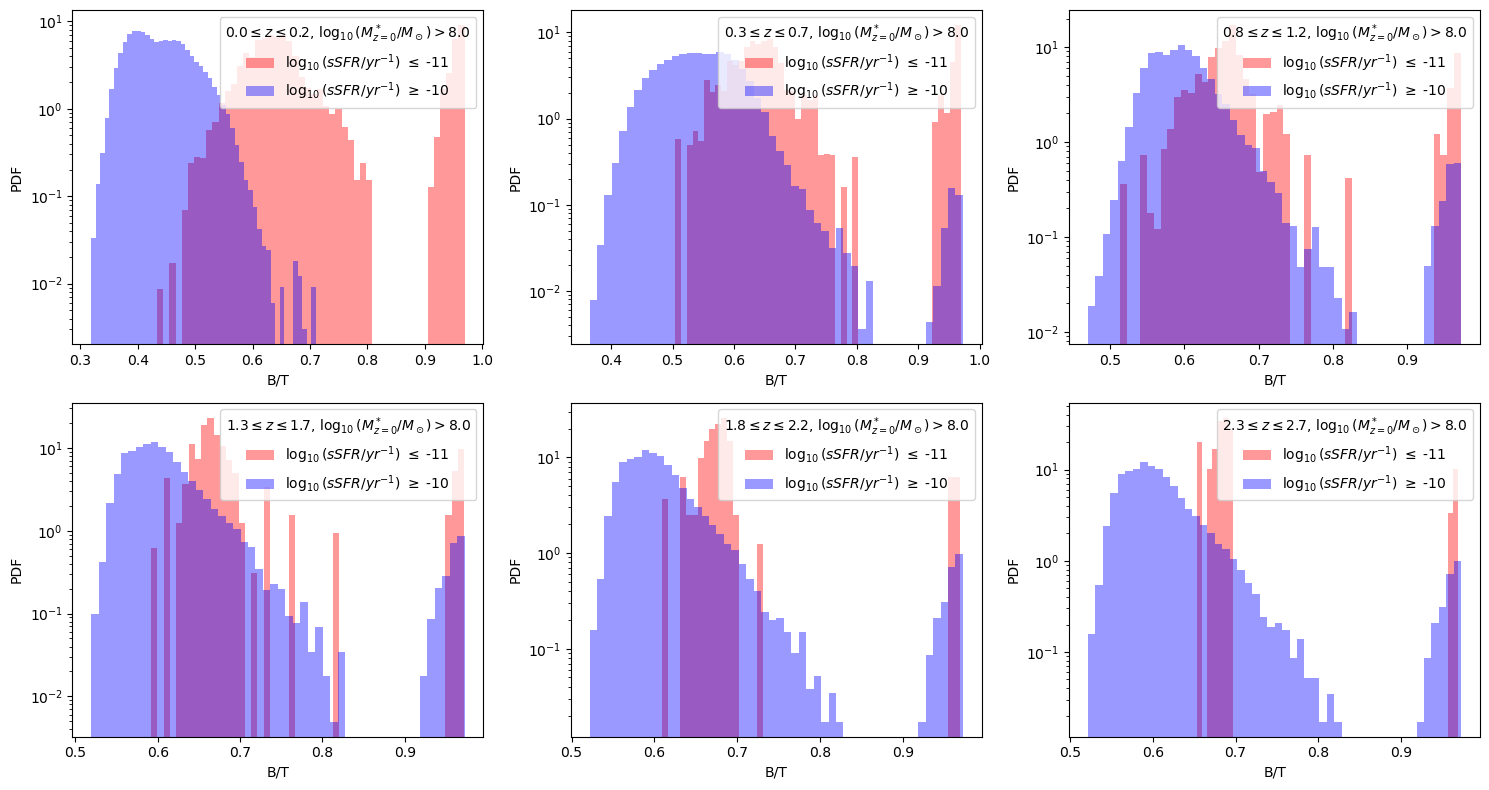

In [15]:
# setup mass mask
logMz0_min = 8.0
mass_mask = np.log10(diffstar_cens["smh"][:, -1]) > logMz0_min
lgnd_title = ", $\\log_{{10}}(M^*_{{z=0}}/M_\\odot) > {:.1f}$".format(logMz0_min)

plot_q_with_cuts(
    diffstar_cens["bth"][mass_mask],
    zvalues,
    redshifts,
    jnp.log10(diffstar_cens["sSFR"])[mass_mask],
    [-11, -10],
    dz=0.2,
    lgnd_title=lgnd_title,
    plotdir=plotdir,
    xname="log_sSFR_new_model",
)

In [ ]:
plot_q_with_cuts(
    diffstar_cens["eff_bulge"][mass_mask],
    zvalues,
    redshifts,
    np.log10(diffstar_cens["sSFR"])[mass_mask],
    [-11, -10],
    dz=0.2,
    pltname="effB_cut_on_{}_new_model.png",
    xlabel="Bulge Efficiency",
    lgnd_title=lgnd_title,
    plotdir=plotdir,
)

In [ ]:
logMz0_min = 8.5
mass_mask = np.log10(diffstar_cens["smh"][:, -1]) > logMz0_min
print(mass_mask.shape)
bins = np.logspace(7, 12, 51)
lgnd_title = ", $\\log_{{10}}(M^*_{{z=0}}/M_\\odot) > {:.1f}$".format(logMz0_min)
# print(lgnd_title)

plot_q_with_cuts(
    diffstar_cens["smh_bulge"][mass_mask],
    zvalues,
    redshifts,
    np.log10(diffstar_cens["sSFR"])[mass_mask],
    [-11, -10],
    dz=0.2,
    pltname="bulge_mass_cut_on_{}_new_model.png",
    xlabel="Bulge Mass ($M_\\odot$)",
    xscale="log",
    bins=bins,
    lgnd_title=lgnd_title,
    plotdir=plotdir,
)

In [ ]:
# logMz0_min = 8.5
# mass_mask = np.log10(diffstar_cens['smh'][:, -1]) > logMz0_min
bins = np.logspace(-14, -7, 71)
mass_bins = np.linspace(7.5, 11.5, 5)
print(mass_bins, np.min(bins), np.max(bins))
# test masking
zmask = redshifts < 0.2
q1_z = diffstar_cens["sSFR_bulge"][:, zmask]
cut_array_z = np.log10(diffstar_cens["smh"])[:, zmask]
cut_mask = (cut_array_z[:, -1] >= 8.5) & (cut_array_z[:, -1] < 11.5)
print(cut_mask.shape, np.where(cut_mask == False)[0][0:2])
cut_mask = np.broadcast_to(cut_mask, (np.count_nonzero(zmask), len(cut_mask))).T
print(cut_mask.shape)

In [ ]:
for m_lo, m_hi in zip(mass_bins[0:-1], mass_bins[1:]):
    plot_q1_q2(
        diffstar_cens["sSFR_bulge"],
        diffstar_cens["sSFR_disk"],
        zvalues,
        redshifts,
        np.log10(diffstar_cens["smh"]),
        m_lo,
        m_hi,
        dz=0.2,
        xname="log_M0_{:.1f}_{:.1f}",
        cut_name="$\\log_{10}(M^*_{z=0}/M_\\odot)$",
        cut_at_z0=True,
        bins=bins,
        plotdir=plotdir,
        pltname="sSFR_cut_on_{}_new_model.png",
    )

Selected 1942 objects
8.065983375619481 11.33020587311464 -25.234810050526846 -9.632499227842146
Selected 1919 objects
7.595688705416053 11.174626042632504 -25.126505813309926 -9.204886295545808
Selected 2042 objects
7.4587130285166445 11.382139565390851 -25.32721536388767 -9.120783899200177
Selected 2009 objects
6.707823953534655 11.234606858038289 -12.694859885370764 -8.801842083291335
Selected 2002 objects
5.844858797717305 11.173926756401233 -12.1061807618377 -8.656441643971162
Selected 2014 objects
5.378618928469703 11.034963880673734 -12.020591376013448 -8.416088479002537
Saving /Users/kovacs/cosmology/BulgeDisk/DiskBulgePlots/DiskBulge_Scatter/sSFR_vs_Mstar_log_M0_min_8.0_logssfr_min_14_new_model.png


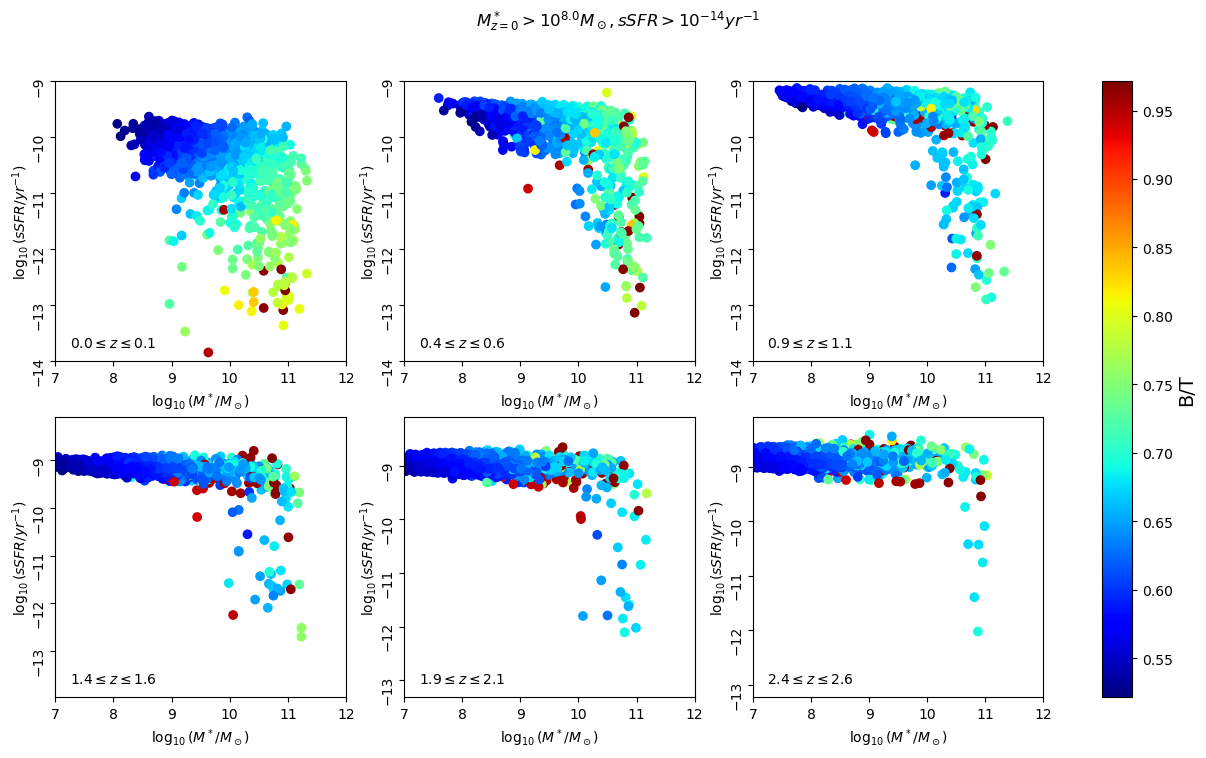

In [14]:
logMz0_min = 8.0
logssfr_min = -14
mass_mask = np.log10(diffstar_cens["smh"][:, -1]) > logMz0_min
title = "$M^*_{{z=0}} > 10^{{{:.1f}}} M_\\odot, sSFR > 10^{{{}}} yr^{{-1}}$".format(logMz0_min, logssfr_min)
xname = "log_M0_min_{:.1f}_logssfr_min_{}".format(logMz0_min, -logssfr_min)
plot_q1_vs_q2(
    jnp.log10(diffstar_cens["smh"][mass_mask]),
    jnp.log10(diffstar_cens["sSFR"][mass_mask]),
    zvalues,
    redshifts,
    diffstar_cens["bth"][mass_mask],
    title=title,
    xname=xname + "_new_model",
    ymin=logssfr_min,
    N=2000,
    plotdir=plotdir,
)

## Fbulge parameter plots with new model

In [ ]:
logMz0_min = 8.0
logssfr_min = -16
mass_mask = np.log10(diffstar_cens["smh"][:, -1]) > logMz0_min
sfr_mask = np.log10(diffstar_cens["sSFR"][:, -1]) > logssfr_min
mask = mass_mask & sfr_mask
title = "$M^*_{{z=0}} > 10^{{{:.1f}}} M_\\odot, sSFR > 10^{{{}}} yr^{{-1}}$".format(logMz0_min, logssfr_min)
xname = "log_M0_min_{:.1f}_logssfr_min_{}".format(logMz0_min, -logssfr_min)
print(diffstar_cens["eff_bulge"][mass_mask].shape)

qs = [diffstar_cens["fbulge_early"][mass_mask], diffstar_cens["fbulge_late"][mass_mask]]
ylabels = ["fbulge_early", "fbulge_late"]

In [ ]:
for q, ylabel in zip(qs, ylabels):
    plot_q_vs_q_x_at_z_scatter(
        q,
        diffstar_cens["tcrit_bulge"][mass_mask],
        ylabel,
        diffstar_cens["eff_bulge"][mass_mask],
        zindexes,
        zs,
        cbar_title="$\\epsilon_{bulge}$",
        title=title,
        xname=xname,
        N=2000,
        plotdir=plotdir,
        xlabel="tcrit_bulge",
        plotsubdir="Fbulge",
        pltname="{}_vs_tcrit_bulge_{}_new_model.png",
    )

In [ ]:
plot_q_vs_q_x_at_z_scatter(
    diffstar_cens["fbulge_late"][mass_mask],
    diffstar_cens["fbulge_early"][mass_mask],
    "fbulge_late",
    diffstar_cens["eff_bulge"][mass_mask],
    zindexes,
    zs,
    cbar_title="$\\epsilon_{bulge}$",
    title=title,
    xname=xname,
    N=2000,
    plotdir=plotdir,
    plotsubdir="Fbulge",
    xlabel="fbulge_early",
    pltname="{}_vs_fbulge_early_{}_new_model.png",
)

In [ ]:
Df = diffstar_cens["fbulge_early"][mass_mask] - diffstar_cens["fbulge_late"][mass_mask]
plot_q_vs_q_x_at_z_scatter(
    Df,
    diffstar_cens["tcrit_bulge"][mass_mask],
    "dfbulge",
    diffstar_cens["eff_bulge"][mass_mask],
    zindexes,
    zs,
    cbar_title="$\\epsilon_{bulge}$",
    title=title,
    xname=xname,
    N=2000,
    plotdir=plotdir,
    xlabel="tcrit_bulge",
    plotsubdir="Fbulge",
    pltname="{}_vs_tcrit_bulge_{}_new_model.png",
)

In [ ]:
# Look at t10, t90 and dt distributions
from diffaux.disk_bulge_modeling.disk_bulge_kernels import (
    calc_tform_pop,
)

tarr = diffstar_cens["t_table"]
smh_pop = diffstar_cens["smh"][mass_mask]
t10 = calc_tform_pop(tarr, smh_pop, 0.1)
t90 = calc_tform_pop(tarr, smh_pop, 0.9)
dt = t90 - t10
tcrit = diffstar_cens["tcrit_bulge"][mass_mask]
early = diffstar_cens["fbulge_early"][mass_mask]
late = diffstar_cens["fbulge_late"][mass_mask]
print(t90.shape, dt.shape, tcrit.shape, early.shape)

In [ ]:
qs = [t10, t90, dt, tcrit, early, late]
ylabels = ["t10", "t90", "dt", "fbulge_{tcrit}", "fbulge_{early}", "fbulge_{late}"]
logM_min = 7.0
logM_max = 11.5
Nm = 36
Mbins = np.linspace(logM_min, logM_max, Nm + 1)

In [ ]:
plot_q_vs_qx_at_z_profile(
    qs,
    jnp.log10(diffstar_cens["smh"])[mass_mask],
    ylabels,
    zindexes,
    zs,
    bins=Mbins,
    title=title,
    xname=xname,
    plotdir=plotdir,
    pltname="t10_90_dt_fbulge_vs_log_Mz_{}_new_model.png",
    plotsubdir="Fbulge",
)

In [ ]:
logsSFR_min = -16
logsSFR_max = -8
Ns = 32
sbins = np.linspace(logsSFR_min, logsSFR_max, Ns + 1)

plot_q_vs_qx_at_z_profile(
    qs,
    jnp.log10(diffstar_cens["sSFR"])[mass_mask],
    ylabels,
    zindexes,
    zs,
    bins=sbins,
    title=title,
    xname=xname,
    xlabel="$\\log_{10}(sSFR*yr)$",
    plotdir=plotdir,
    plotsubdir="Fbulge",
    pltname="t10_90_dt_fbulge_vs_log_sSFR_{}_new_model.png",
    colors=("b", "g", "c", "r", "darkorange", "m"),
)

## B/T Plots

In [ ]:
logMz0_min = 8.0
logssfr_min = -15
mass_mask = np.log10(diffstar_cens["smh"][:, -1]) > logMz0_min
sfr_mask = np.log10(diffstar_cens["sSFR"][:, -1]) > logssfr_min
mask = mass_mask & sfr_mask
title = "$M^*_{{z=0}} > 10^{{{:.1f}}} M_\\odot, sSFR > 10^{{{}}} yr^{{-1}}$".format(logMz0_min, logssfr_min)
xname = "log_M0_min_{:.1f}_logssfr_min_{}".format(logMz0_min, -logssfr_min)

In [ ]:
plot_q1_vs_q2(
    jnp.log10(diffstar_cens["sSFR"][mask]),
    diffstar_cens["bth"][mask],
    zvalues,
    redshifts,
    jnp.log10(diffstar_cens["smh"][mask]),
    title=title,
    xname=xname,
    cbar_title="$\\log_{10}(M^*/M_\\odot)$",
    N=3000,
    xmin=-14,
    xmax=-8.4,
    ymin=0,
    ymax=1.0,
    ylabel="B/T",
    xlabel="$\\log_{10}(sSFR/yr)$",
    pltname="BoverT_vs_sSFR_{}_new_model.png",
    plotdir=plotdir,
)

In [ ]:
plot_q1_vs_q2(
    jnp.log10(diffstar_cens["smh"][mask]),
    diffstar_cens["bth"][mask],
    zvalues,
    redshifts,
    jnp.log10(diffstar_cens["sSFR"][mask]),
    title=title,
    xname=xname,
    cmap="jet_r",
    N=2000,
    ymin=0,
    ymax=1.0,
    xmin=7,
    xmax=12,
    xlabel="$\\log_{10}(M^*/M_\\odot)$",
    ylabel="B/T",
    cbar_title="$\\log_{10}(sSFR/yr)$",
    pltname="BoverT_vs_logMstar_{}_new_model.png",
    plotdir=plotdir,
)

In [ ]:
plot_q1_vs_q2(
    diffstar_cens["eff_bulge"][mask],
    diffstar_cens["bth"][mask],
    zvalues,
    redshifts,
    jnp.log10(diffstar_cens["smh"][mask]),
    title=title,
    xname=xname,
    cmap="jet",
    N=2000,
    ymin=0,
    ymax=1.0,
    xmin=0,
    xmax=1.0,
    xlabel="$\\epsilon_{bulge}$",
    ylabel="B/T",
    cbar_title="$\\log_{10}(M^*/M_\\odot)$",
    pltname="BoverT_vs_eff_bulge_{}_new_model.png",
    plotdir=plotdir,
)

In [ ]:
# profiles
qs = [diffstar_cens["bth"][mask], diffstar_cens["eff_bulge"][mask]]
ylabels = ["B/T", "\\epsilon_{bulge}"]
logM_min = 7.0
logM_max = 11.5
Nm = 9
Mbins = np.linspace(logM_min, logM_max, Nm + 1)
logsSFR_min = -16
logsSFR_max = -8
Ns = 8
sbins = np.linspace(logsSFR_min, logsSFR_max, Ns + 1)

In [ ]:
plot_q_vs_qx_at_z_profile(
    qs,
    jnp.log10(diffstar_cens["smh"][mask]),
    ylabels,
    zindexes,
    zs,
    bins=Mbins,
    title=title,
    xname=xname,
    plotdir=plotdir,
    pltname="BoverT_vs_log_Mz_{}_new_model.png",
    errors=[True, True],
    qs_depends_z=True,
)

In [ ]:
plot_q_vs_qx_at_z_profile(
    qs,
    jnp.log10(diffstar_cens["sSFR"])[mask],
    ylabels,
    zindexes,
    zs,
    bins=sbins,
    title=title,
    xname=xname,
    xlabel="$\\log_{10}(sSFR*yr)$",
    plotdir=plotdir,
    pltname="BoverT_vs_log_sSFR_{}_new_model.png",
    errors=[True, True],
    qs_depends_z=True,
)